**Binôme**
- Sophia Lazraq
- Benjamin Muller

## Spectral Clustering and Semi-Supervised Learning

#### This notebook contains different values and imports that can be used in this practical session.
#### Please keep the same variable names when provided in your report to make the work of teaching assistants easier. 
#### You can still change the values given or the sizes of the datasets treated if you believe it is usefull to illustrate your point.

#### You can directly edit the markdown boxes to add your comments and answers to the questions

In [1]:
# Question 1 (imports and advised values):
from sklearn.datasets import make_moons
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

n_samples = 200 # You can change these values
noise_level_list = [.05,.1,.2] # You can change these values

### Question 1 : Complete the code in the box below

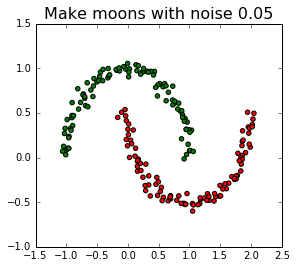

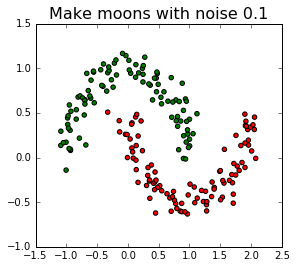

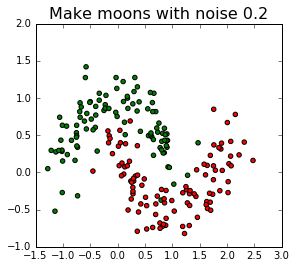

In [2]:
#we define a dictionnary that will include all the data sample we wil study

noise_level_list = [.05,.1,.2] 
ls_moons=[make_moons(n_samples=n_samples, noise=noise) for noise in noise_level_list]
getColors = lambda y : ['red' if yy==1 else 'green' for yy in y]

for i in range(len(noise_level_list)):
    #noisy_moons = make_moons(n_samples=n_samples, noise=noise)
    plt.figure(figsize=(15.0, 4.0))
    plt.subplot(1, 3, 1)
    plt.title("Make moons with noise "+ str(noise_level_list[i]), fontsize=16)
    plt.scatter(x=ls_moons[i][0][:,0],y=ls_moons[i][0][:,1],c=getColors(ls_moons[i][1]))


In [3]:
# Question 2 :
from sklearn.neighbors import kneighbors_graph
n_neighbors_list = [2,10,15,20]

### Question 2 : Complete the code in the box below

Our goal is to build a graph. 
We're using the knn algorithm in this purpose.
We can represent the graph with the adjancy matrix W and with the a plot of our points related according to how the graph has been built.
We do that for a few value of noise and a few values of k.
Around k=10 this should have a good head.

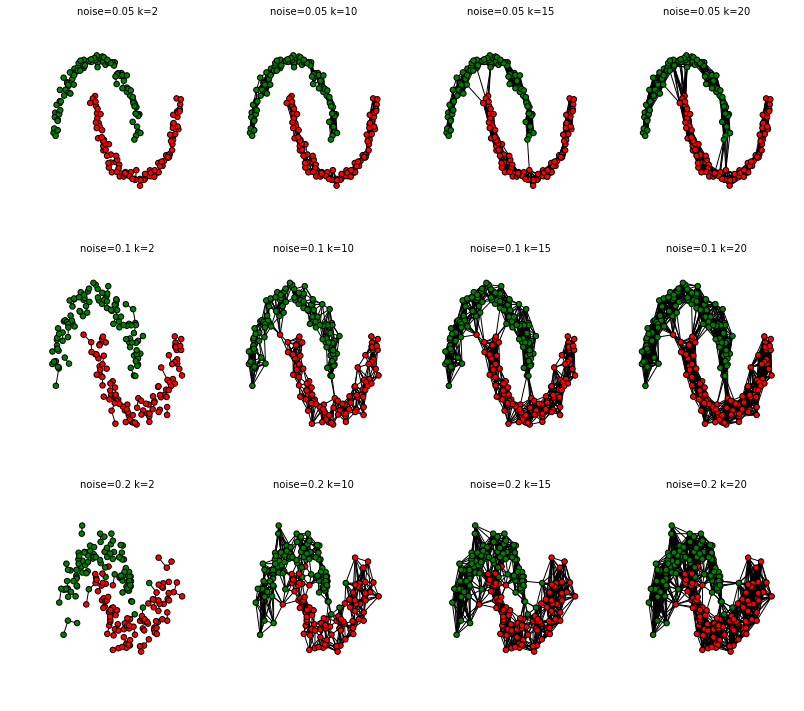

In [4]:
from sklearn.cluster import SpectralClustering
SpectralClustering(n_clusters=82)
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import networkx as nx

#networkx need the position of each observation as a dictionnary
def getPosition(data):
    position = {}
    for ind, X in enumerate(data): position[ind] = tuple(X)
    return position

#we build a graph for each value of nois
i=0
j=0
plt.figure(figsize=(len(noise_level_list)*4.5, len(n_neighbors_list)*3.))
for noise in noise_level_list:
    for k in n_neighbors_list:
        j=j+1
        #we build the graph matrix
        Ad=kneighbors_graph(ls_moons[i][0],k,mode='connectivity',include_self=True)
        #the nx.draw needs a dense matrix as an input
        Graph=nx.from_numpy_matrix(Ad.todense())
        colors = getColors(ls_moons[i][1])
        pos = getPosition(ls_moons[i][0])

        plt.subplot(len(noise_level_list),
                len(n_neighbors_list),
                j)
        plt.title('noise=' + str(noise) + ' k=' + str(k), size=10)
        nx.draw(Graph, pos ,node_size=30, node_color=colors)
    i=i+1
plt.show()


We can highlight here an intuitive phenomenon. 
- If k is too small, the connection within each observed cluster don't seem to be strong enough. 
- If k is too big, we observe lots of connections between clusters.

In both these cases, it seems that the graph built doesn't capture the structure of each cluster.

k=10 seems to be a good-enough value to build relevant graphs.


### Question 3 : Optimization problem 

- Given the graph $G=(V,E)$  and its adjacency matrix $W=(w_{ij})$, the <strong>normalized cut </strong> loss function is: 
$$
Ncut(A,B) := \frac{cut(A,B)}{vol(A)} + \frac{cut(B,A)}{vol(B)}
$$
where A and B represents the vertices and the intersection of A and B is null.
We define the cut and the volume as follows:
$$cut(A,B) := \sum_{t \in A, u \in B} w_{t,u}$$
$$vol(A):=\sum_{t \in A, u \in V} w_{t,u}$$
We define $f_i = \sqrt{\frac{vol(B)}{vol(A)}}$ if $v_i \in A$, $f_i=\sqrt{\frac{vol(A)}{vol(B)}}$ if $v_i \in B$, and $D$ as $D_{ii} = \sum_{j} w_{ij}$ 
,then we have
$$vol(V) = f^\top D f$$
where
$$(Df)^\top 1 = 0$$
Then
$$f^\top L f = vol(V) Ncut(A,B)$$
The optimization problem can be formulated as:
$$\min_{f \in \mathbb{R}^n} \frac{f^\top L f}{f^\top D f}$$
subject to
$$\boxed{f^\top D 1_n = 0}$$


- Intuitively it means that we're trying to build clusters based on our graph by minimising the connections between clusters in a normalized manner (in order to avoid to get trivial clusters).


### Question 4 : Complete the code in the box below



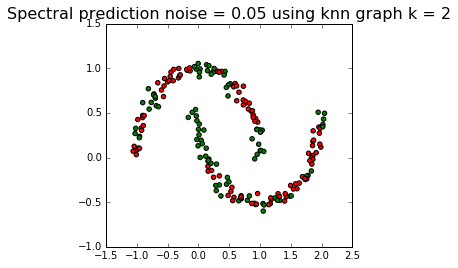

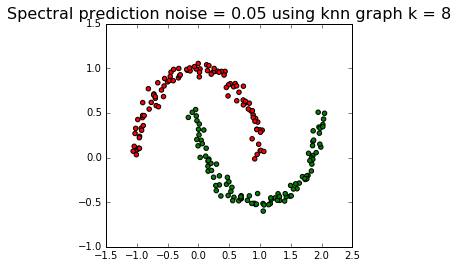

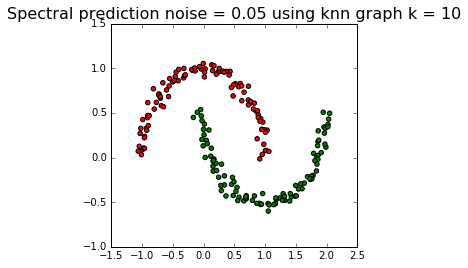

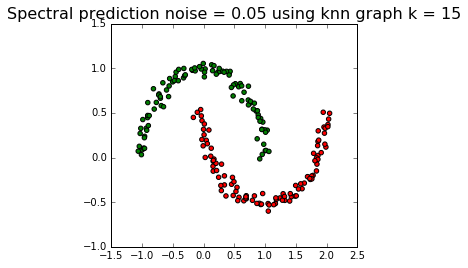

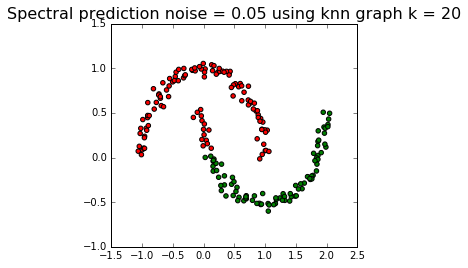

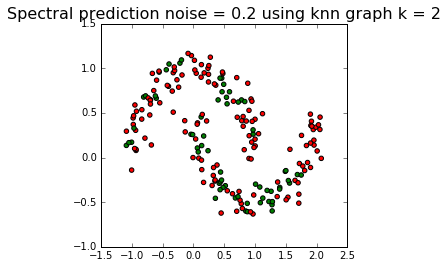

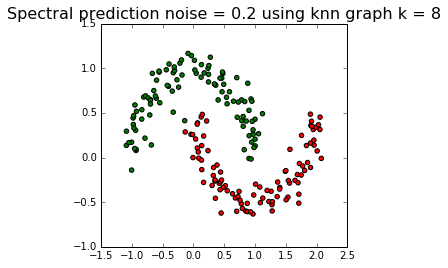

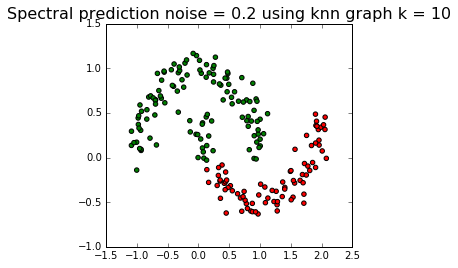

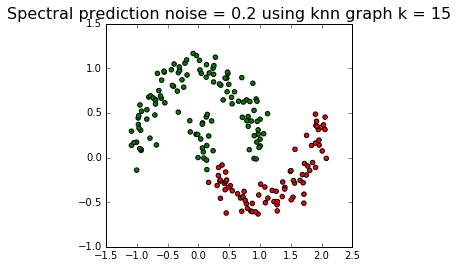

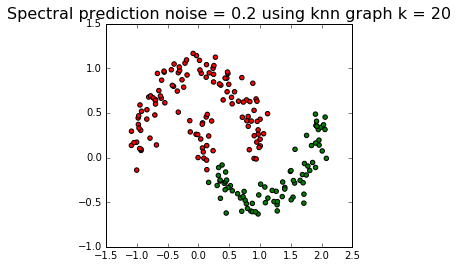

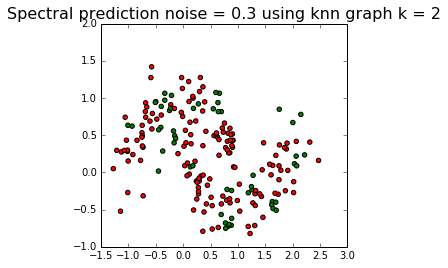

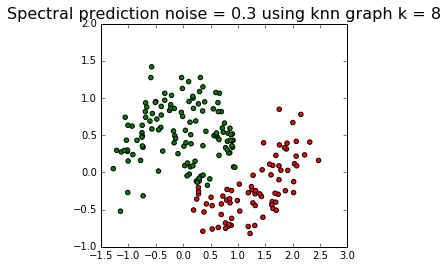

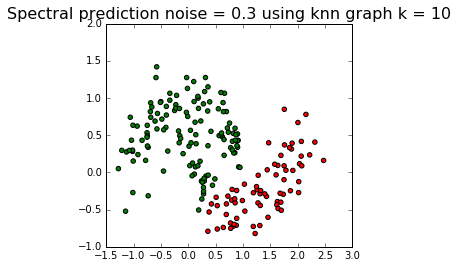

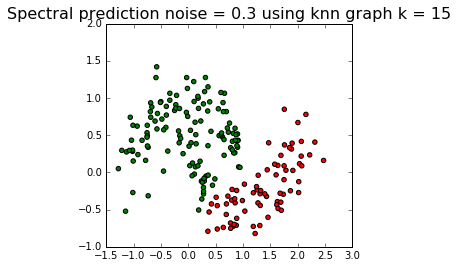

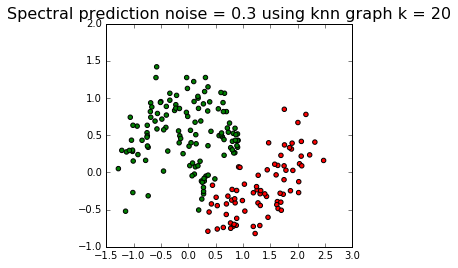

In [7]:
from sklearn.cluster import SpectralClustering
import scipy as sp

i=0
noise_level_list = [0.05,0.2,0.3]
n_neighbors_list=[2,8,10,15,20]
for noise in noise_level_list:
    for k in n_neighbors_list:
        spectral = SpectralClustering(n_clusters=2
                              ,eigen_solver='arpack'
                              ,affinity="nearest_neighbors"
                              ,n_neighbors=k              
                             )
        spectral_clustering=spectral.fit_predict(ls_moons[i][0])
        plt.figure(figsize=(15.0, 4.0))
        plt.subplot(1, 3, 1)
        plt.title("Spectral prediction noise = "+ str(noise_level_list[i]) + " using knn graph k = "+str(k), fontsize=16)
        plt.scatter(x=ls_moons[i][0][:,0],y=ls_moons[i][0][:,1],c=getColors(spectral_clustering))
    i=i+1
 
 # plot


We applied the spectralClustering function. In the way we used it, this function build a knn graph for the given value of k, and apply the two-ways spectral clustering on this graph. 
We outputed the predicted scatter plot for a few values of noise and k.

Answer : 

- For small value of noise (below 0.05) , if k is high enough, more specifically above 8, the clustering algorithm is working perfectly
- For higher value of noise above 0.1, k=10 seem to be the most consistent value of neighboors. 

Answer:
For small value of k (we observe it for k =2), there are many sub_clusters, so the prediction is not accurate.


### Question 5 : Complete the code in the box below

The idea is to measure how stable are the clusters.
For a given level of noise , we proceed as follows:
- We construct a "bootstrap" by selecting 80% of the observations of the full dataset
- We use an algorithm (here,spectral Clustering) to cluster these data
- From that we build matrices C1 and C2 which are defined for the full sample and the bootstrap
- We compare these two matrix with a specific distance (here, cosine similarity)
- We obtain a real number c 
- We do that for 10 (and 20) bootstrap samples ==> this give us a measure of stability for this specific clustring algorithm (e.g. depend on k)

- We do that for several clustering algorithm and we compare for different values of k

In [8]:
def partition_representation(y, size):
    return np.array([[int(y[i] == y[j]) for j in range(size)] for i in range(size)])

def dot_roduct(A, B):
    ret = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]): ret+= int(A[i,j] == B[i,j])
    return ret

def distance_matrices(A,B):
    return float(dot_roduct(A,B)) / (np.sqrt(dot_roduct(A,A) * dot_roduct(B,B)))

def stability(clustering, data, B, C, bootstrap_size):    
    n_row, _ = data.shape
    bootstrap_size = int(n_row * bootstrap_size)
    ret = 0
    bootstrap=[]
    for b in range(B):
        
        permutation = np.random.permutation(range(n_row))
        indices_bootstrap = permutation[:bootstrap_size]
        bootstrap.append(choice(n_samples,0.8*n_row))

        prediction_full = clustering.fit_predict(data)[bootstrap[b]]#we fit and we select the data we want to compare
        # Predictions on bootstrap data
        data_bootstrapped = data[bootstrap[b]] # Bootstrap data
        bootstrapped_prediction = clustering.fit_predict(data_bootstrapped)
        # Compute partionned matrices
        C_matrix_full = partition_representation(y=prediction_full, size=bootstrap_size)
        C_matrix_bootstrap = partition_representation(y=bootstrapped_prediction, size=bootstrap_size)
        # distance between both matrices
        ret+= distance_matrices(C_matrix_full, C_matrix_bootstrap)
    return float(ret) / B


In order to check the solution, we apply our stability measure algorithm to the SpectralClustering algorithm (for 2 cluster, 10 neighboors) with 10, 20 and 30 bootstraps  bootsraps. 

In [9]:
from numpy.random import choice
n_samples=200
B=10
cluster = SpectralClustering(n_clusters=2,
                             affinity='nearest_neighbors',
                             n_neighbors=10)

#stability(cluster, ls_moons[1][0],B=10,C=2,bootstrap_size=0.8)

B_10=stability(cluster, ls_moons[1][0],B=10,C=2,bootstrap_size=0.8)
print("Stability with 10 iterations:" + str(B_10))

B_20=stability(cluster, ls_moons[1][0],B=20,C=2,bootstrap_size=0.8)
print("Stability with 20 iterations:" + str(B_20))

B_30=stability(cluster, ls_moons[1][0],B=20,C=2,bootstrap_size=0.8)
print("Stability with 30 iterations:" + str(B_30))


Stability with 10 iterations:0.7577421875
Stability with 20 iterations:0.82294140625
Stability with 30 iterations:0.75003515625


### Question 6 : Complete the code in the box below

In [10]:
#careful here ls_moons defined and noise_level_list defined must be consistent

#function that define the data given noise value, 
#launch the spectralClutering algoritm and measure its stabitlity
def apply_stability_measure(noise_level_list,n_neighbors_list,B,C,bootstrap_size):
    i=0
    dic={}
    ls_moons_def=[make_moons(n_samples=n_samples, noise=noise) for noise in noise_level_list]
    for noise in noise_level_list:
        for k in n_neighbors_list: 
            cluster = SpectralClustering(n_clusters=2,
                            affinity='nearest_neighbors',
                             n_neighbors=k)
            dic[(k,noise)] = stability(cluster, ls_moons_def[i][0],B,C,bootstrap_size)
        i=i+1
    return dic

#Take noisy and non-noisy datasets
#Displaying the different values of stability per noise and per value of k
noise_level_list_def=[0.05,0.2]
n_neighbors_list_def=[5,6,7,8,9,10,11,12,13,14]
stability_measures=apply_stability_measure(noise_level_list=noise_level_list_def,n_neighbors_list=n_neighbors_list_def,B=10,C=2,bootstrap_size=0.8)

for e in stability_measures:
    print ("k="+ str(e[0])+" noise="+str(e[1])+" stability measure : "+str(stability_measures[e]))



k=12 noise=0.2 stability measure : 0.7675703125
k=13 noise=0.2 stability measure : 0.8177265625
k=10 noise=0.2 stability measure : 0.7240234375
k=6 noise=0.05 stability measure : 0.6321328125
k=5 noise=0.05 stability measure : 0.592640625
k=9 noise=0.2 stability measure : 0.7614140625
k=7 noise=0.05 stability measure : 0.8351484375
k=10 noise=0.05 stability measure : 0.9691953125
k=12 noise=0.05 stability measure : 0.8914765625
k=14 noise=0.05 stability measure : 0.9643125
k=13 noise=0.05 stability measure : 0.920078125
k=5 noise=0.2 stability measure : 0.5765625
k=7 noise=0.2 stability measure : 0.7344765625
k=11 noise=0.2 stability measure : 0.7824453125
k=8 noise=0.2 stability measure : 0.7586328125
k=8 noise=0.05 stability measure : 0.7797421875
k=14 noise=0.2 stability measure : 0.8210703125
k=9 noise=0.05 stability measure : 0.8086484375
k=6 noise=0.2 stability measure : 0.725171875
k=11 noise=0.05 stability measure : 0.98365625


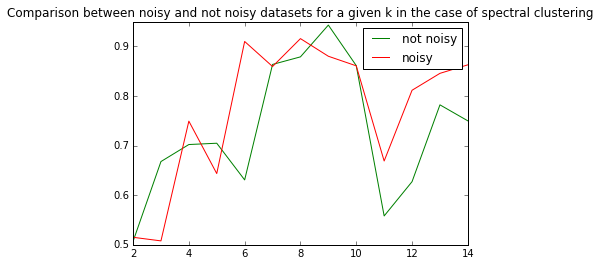

In [12]:
#Plot the stability
noisy=[0.2]
not_noisy=[0.05]
n_neighbors_list_def=list(range(2,15))
stability_measures_noisy=apply_stability_measure(noise_level_list=noisy,n_neighbors_list=n_neighbors_list_def,B=10,C=2,bootstrap_size=0.8)
stability_measures_not_noisy=apply_stability_measure(noise_level_list=not_noisy,n_neighbors_list=n_neighbors_list_def,B=10,C=2,bootstrap_size=0.8)

liste_noisy=[]
for i in stability_measures_noisy.values():
    liste_noisy.append(i)
    
liste_not_noisy=[]
for i in stability_measures_not_noisy.values():
    liste_not_noisy.append(i)
    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(n_neighbors_list_def,liste_not_noisy,"green",label="not noisy")
ax.plot(n_neighbors_list_def,liste_noisy,"red",label="noisy")
plt.title("Comparison between noisy and not noisy datasets for a given k in the case of spectral clustering")
ax.legend()
plt.show()


We notice that globally the stability is better for not noisy samples.

For non-noisy data set  : 

After a few trials, it's clear that the most stable algorithm is for k between 7 and 13.
We re-run the algorithm for all these values.
We found that k=10 or k=11 have the best stability measure


### Question 7 : Complete the code in the box below

We now want to measure the stability of the hierarchical clustering algorithm

In [13]:

from sklearn.cluster import AgglomerativeClustering

hierarchical_clustering = AgglomerativeClustering(n_clusters = 2,
                                linkage= 'complete')
hierarchical_clustering_stability_non_noisy = stability(hierarchical_clustering
                                              , ls_moons[0][0]
                                              , B=10
                                              , C=2
                                              , bootstrap_size=0.8)
hierarchical_clustering_stability_noisy = stability(hierarchical_clustering
                                              , ls_moons[2][0]
                                              , B=10
                                              , C=2
                                              , bootstrap_size=0.8)

In [14]:
print ("stability hierarchical clustering algorithm noise=0.05 : ", hierarchical_clustering_stability_non_noisy)
print ("stability hierarchical clustering algorithm noise=0.2 : ", hierarchical_clustering_stability_noisy)

('stability hierarchical clustering algorithm noise=0.05 : ', 0.82396875)
('stability hierarchical clustering algorithm noise=0.2 : ', 0.6851484375)


In [15]:
print("Noisy dataset:")
print("hierarchical:",hierarchical_clustering_stability_noisy,"vs spectral clustring",max(liste_noisy))
print("Non-noisy dataset:")
print("hierarchical:",hierarchical_clustering_stability_non_noisy,"vs spectral clustring",max(liste_not_noisy))

Noisy dataset:
('hierarchical:', 0.6851484375, 'vs spectral clustring', 0.9156953124999999)
Non-noisy dataset:
('hierarchical:', 0.82396875, 'vs spectral clustring', 0.9429687500000001)


Spectral Clustering is more stable in both cases (noisy and not noisy).
Indeed, after we selected a good value of k for spectral clustering we get better results for spectral clustering whether the datase is noisy or not.

### Experiment on MNIST

In [9]:
from sklearn.datasets import load_digits
import numpy as np
from matplotlib import pyplot as plt

Mnist = load_digits(10)
X = Mnist.data
y = Mnist.target # 10 classes to predict 
#print y.shape
def stratified_subsampling(y,percent = 0.5):
    output = []
    for i in np.unique(y):
        indices = np.where(y == i)[0]
        output.extend(np.random.choice(indices,
                         size = round(percent*len(indices)),
                         replace = False))
    return(output)

subsampling = stratified_subsampling(y,percent = 0.3)

#we build our stratified samples
X_subsample = X[subsampling,:]
y_subsample = y[subsampling]

In [14]:
k_list = [10,11,12,13,15,18,20]
nb_cluster_list = [3,5,9,10,11,12]
res_stability = []
for k in k_list:
    for C in nb_cluster_list:
        spectral_clustering = SpectralClustering(n_clusters= C,
                              affinity='nearest_neighbors',
                              n_neighbors= k)
        spectral_clustering.fit(X_subsample)
        stab = stability(spectral_clustering, X_subsample,B=5,C=C,bootstrap_size=0.8)
        print ("k :",k ,"C :",C, "stability :", stab)
        res_stability.append(stab)



k : 10 C : 3 stability : 0.8239716625125834
k : 10 C : 5 stability : 0.8299341627144556
k : 10 C : 9 stability : 0.9013808065202061
k : 10 C : 10 stability : 0.9189560779711565
k : 10 C : 11 stability : 0.9151167360210163
k : 10 C : 12 stability : 0.9151533421977701
k : 11 C : 3 stability : 0.7217629104063823
k : 11 C : 5 stability : 0.871264689574238
k : 11 C : 9 stability : 0.9100758501515388
k : 11 C : 10 stability : 0.929526649835003
k : 11 C : 11 stability : 0.9110168442245682
k : 11 C : 12 stability : 0.9103536264339661
k : 12 C : 3 stability : 0.7928973250574662
k : 12 C : 5 stability : 0.8012822928386475
k : 12 C : 9 stability : 0.9059415054828517
k : 12 C : 10 stability : 0.9138204467030218
k : 12 C : 11 stability : 0.9103019471256075
k : 12 C : 12 stability : 0.9009716786623672
k : 13 C : 3 stability : 0.8463423431183079
k : 13 C : 5 stability : 0.8331038269604493
k : 13 C : 9 stability : 0.9029268791619339
k : 13 C : 10 stability : 0.8869751993152493
k : 13 C : 11 stability 

- We notice that when k is high enough, no matter the value for C we get a very stable clustering. We have a stability of around 0.88
- For smaller value of k, we find that choosing C = 9 is the best

The eigengap method is an heuristic method in order to choose the number of cluster in our spectral clustering algorithm. In a few words, this method is based on the eigen values of the laplacian. We choose the number of cluster k that discrimine the most between lowest eigen values and highest eigen values. 

<Container object of 3 artists>

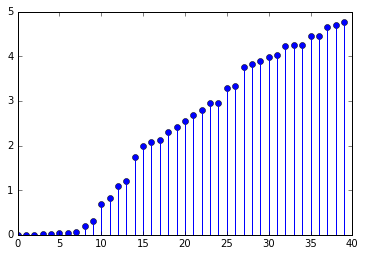

In [18]:
from numpy import linalg as linalg
#eigen gap method
W_adj_sparse= kneighbors_graph(X_subsample, 10, mode='connectivity', include_self=True)
W_adj = W_adj_sparse.todense()
D = np.diag(np.apply_along_axis(sum,1,W_adj))
Lap = D-W_adj
eig = linalg.eigvals(Lap)
eig_ = eig.sort()
plt.stem(eig[0:40])

By applying this eigengap method, we can assume that the best value for k is 10 which is the value we found with our stability measure.

## Semi-Supervised Learning

Choice of the dataset used : **Precise** which dataset you chose and why it is relevant for the semi-supervised learning Task:

We choosed Cancer datasets because there are enough samples (569) and it contains two classes that are rather balanced (212 vs 257).



In [13]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.cross_validation import train_test_split


### For all the next questions, use Cancer and Mnist classes to handle your data if you choose to use these one,
### You can also add more datasets but we advise you to handle them with this class for better readability
class semi_sup_dat:
    def __init__(self,data,p_unlabelled,name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]
            Y = [int(y in even) for y in data.target]
        else:
            Y = data.target
        #X_lab, X_unlab, y_lab, y_unlab = train_test_split(data.data, data.target, test_size=p_unlabelled, random_state=32)
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(data.data, Y, test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab

#Binome 2:
# The following lines can be called later in the code to build a dataset with varying unlabelled proportion
p_unlabelled = 0.8 # You can change this value
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
class semi_sup_dat_2:
    def __init__(self,data,p_unlabelled,name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]
            Y = [int(y in even) for y in data[1]]
        else:
            Y = data[1]
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(data[0], data[1], test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab

# The following lines can be called later in the code to build a dataset with varying unlabelled proportion
# You can change this value
p_unlabelled = 0.8
cancer = load_breast_cancer()
cancer_X_lab, cancer_X_unlab, cancer_y_lab, cancer_y_unlab = train_test_split(cancer.data, cancer.target, 
                                                            train_size=p_unlabelled, random_state=32)
cancer_dataset = semi_sup_dat_2((cancer_X_lab,cancer_y_lab), p_unlabelled,'Cancer')

### Question 9 : Complete the code in the box below

('Accuracy of the self training function on non-noisy moon dataset is equal to ', 1.0)


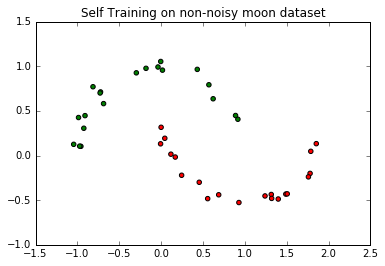

In [14]:
#  Question 9  : Complete the function self_training
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

#step 1:Learn f_k by training on S_k=S
#step 2: Use f to label X_u and keep the most confident
#uk labeled data and build S_k+1 new set of l+u_k labeled data
#step 3: learn f_k+1 by training on S_k+1
#step 4: if D(f_k+1,f_k) is small then stop else go to step 2-->pass/epoch on all unlabelled data
def self_training(S,y_lab,X_unlab,k):
    kNeighbor=KNeighborsClassifier(n_neighbors=k)
    for k in range(len(X_unlab)):
        l_model=kNeighbor.fit(S,y_lab)
        c_all=l_model.predict_proba(X_unlab)
        c_arg=np.argmax(c_all)
        c_pos=c_arg//2
        c=X_unlab[c_pos]
        X_unlab=np.delete(X_unlab,c_pos,axis=0)
        S=np.concatenate((S,c[None,:]))
        y_lab=np.concatenate((y_lab,[c_arg % 2]))
    return kNeighbor

#Test on non-noisy moon dataset
X_lab_moon,X_unlab_moon ,y_moon_lab,y_moon_unlab = train_test_split(ls_moons[0][0],
                                                                    ls_moons[0][1], 
                                                    train_size=0.8, random_state=32)
p_unlabelled_moon = 0.8
function_trained = self_training(X_lab_moon,y_moon_lab,X_unlab_moon,10)
moon_test_predict = function_trained.predict(X_unlab_moon)
#Compute an accuracy_score
accuracy_moon = accuracy_score(moon_test_predict,y_moon_unlab)
print("Accuracy of the self training function on non-noisy moon dataset is equal to ", accuracy_moon)
#Plot
plt.title("Self Training on non-noisy moon dataset")
plt.scatter(x=X_unlab_moon[:,0],y=X_unlab_moon[:,1],c=getColors(moon_test_predict))
plt.show()


In [15]:
## Real dataset chosen : Cancer 
S = cancer_dataset.X_lab
y_lab= cancer_dataset.y_lab
X_unlab = cancer_dataset.X_unlab
function_cancer = self_training(S,y_lab,X_unlab,7)
cancer_u_predict = function_cancer.predict(cancer_X_unlab)
accuracy_cancer = accuracy_score(cancer_u_predict,cancer_y_unlab)
print("Accuracy of the self training function on cancer dataset is equal to", accuracy_cancer)

('Accuracy of the self training function on cancer dataset is equal to', 0.85964912280701755)


### Question 10 : Complete the code in the box below

###### Closed form expression :

NB : We assumed a null intercept.

The loss function is $$\min_{f \in \mathcal{H}_K} \frac{1}{l} \sum_{i=1}^l (y_i - f(x_i))^2 + \lambda \| f \|_K^2 + \frac{\lambda_u}{(u+l)^2} \mathbf{f}^\top L \mathbf{f}$$
The form of the minimiser is:
$$
f^*(x) = \sum_{i=1}^l \alpha^*_i K(x,x_i)
$$
Thus, we have to find
$$ \alpha ^ * = \arg \min_{\alpha \in \mathbb{R}^{l+u} }\frac{1}{l} (Y- JK \alpha)^\top (Y- JK \alpha) + \lambda \alpha^\top K \alpha + \frac{\lambda_u}{(u+l)^2} \alpha^\top KLK \alpha$$


The solution is as follows:
$$
\boxed{\alpha^* = (JK + \lambda l \cdot Id_n + \frac{\lambda_u l}{(u+l)^2} LK )^{-1} Y}
$$



### Question 11 : Complete the code in the box below

In [16]:
from sklearn.metrics.pairwise import rbf_kernel # Or reimplement it yourself if your prefer
from scipy.linalg import block_diag
from scipy.sparse import csgraph

#data moons init
n_samples_2 = 200
ls_moons2=[make_moons(n_samples=n_samples_2, noise=noise) for noise in [0.05,0.2]]
#moons = semi_sup_dat(ls_moons2,p_unlabelled,"Moons") 
#number of labeled and unlabeled data
l = 100
u = 100
J = block_diag(np.identity(l),np.zeros(shape=(u,u)))
W_adj = kneighbors_graph(ls_moons2[0][0],2,mode='connectivity',include_self=True).todense()
L=csgraph.laplacian(W_adj)
# we make L symetrical by considering that we only keep connection that are symetrical 
#the other connections are set to one
L = (0.5*L+0.5*np.transpose(L)).astype(int)
K = rbf_kernel(ls_moons2[0][0],gamma=None)

In [17]:
def alpha_compute(gamma_A,gamma_l,J,K,L,Y,l,u):
    inv = np.linalg.inv(np.dot(J,K)+gamma_A*l*np.identity(u+l)+gamma_l*l*(u+l)**(-2)*np.dot(L,K))
    return inv.dot(Y)
def f_alpha(alpha,K=K):
    return K.dot(alpha)

#the pb is with Y 
def lapRLS_analytics(X_lab, X_unlab, y_lab, y_unlab ,adjancy_matrix,gamma_A,gamma_l):#,unlabeled=u,labeled=l):
    X_tot =  np.concatenate((X_lab,X_unlab),axis=0)  ###???? there was (around adj)
    dim_labeled = X_lab.shape[0]
    dim_unlabeled = X_unlab.shape[0]
    J = block_diag(np.identity(dim_labeled),np.zeros(shape=(dim_unlabeled,dim_unlabeled)))
    L = csgraph.laplacian(adjancy_matrix)
    L = (0.5*L+0.5*np.transpose(L)).astype(int)
    K = rbf_kernel(X_tot,gamma=None)
    Y = np.concatenate((y_lab,y_unlab),axis=0)
    alpha_computed = alpha_compute(gamma_A,gamma_l,J=J,K=K,L=L,Y=Y,l=dim_labeled,u=dim_unlabeled)
    f_alpha_computed = f_alpha(alpha=alpha_computed,K=K)
    prediction = [1 if x>=0 else -1 for x in f_alpha_computed]
    return alpha_computed, f_alpha_computed, prediction

In [18]:
#initialize data for moons 
n_samples_2 = 250
ls_moons2=[make_moons(n_samples=n_samples_2, noise=noise) for noise in [0.05,0.2]]
W_adj = kneighbors_graph(ls_moons2[0][0],2,mode='connectivity',include_self=True).todense()
l = 100
u = 150
X_lab = ls_moons2[0][0][0:l,:]
X_unlab = ls_moons2[0][0][l:l+u,:]
Y_lab = np.array([x if x==1 else -1 for x in ls_moons2[0][1][0:l]])
Y_unlab = np.zeros(u)
X_tot = np.concatenate((X_lab,X_unlab),axis=0)

In [19]:
def compute_lapRLS_prediction_list_analytics(X_lab,X_unlab,Y_lab,Y_unlab,W_adj,gamma_l_list,gamma_A=0.03125):#, unlabeled, labeled):
    lapRLS_prediction_list = []
    alphas = {}
    predictions = {}
    for gamma_l_tested in gamma_l_list :
        lapRS = lapRLS_analytics(X_lab=X_lab
                          ,X_unlab=X_unlab
                         ,y_lab=Y_lab
                          ,y_unlab=Y_unlab
                          ,adjancy_matrix=W_adj
                          ,gamma_A=gamma_A,gamma_l=gamma_l_tested
                    )
        predictions[(gamma_A,gamma_l_tested)] = lapRS[2]
        alphas[(gamma_A,gamma_l_tested)] = lapRS[0]
        #to be removed :
        lapRLS_prediction_list.append(lapRLS_analytics(X_lab=X_lab
                          ,X_unlab=X_unlab
                          ,y_lab=Y_lab
                          ,y_unlab=Y_unlab
                          ,adjancy_matrix=W_adj
                          ,gamma_A=gamma_A,gamma_l=gamma_l_tested
                          #,unlabeled = unlabeled
                          #,labeled = labeled
                       )[2])
    return lapRLS_prediction_list, gamma_l_list, alphas, predictions


In [20]:
from matplotlib import gridspec
def plot_binary_classification(x_coordinate,y_coordinate,binary_prediction,add_title=""):
    getColors = lambda y : ['red' if yy==1 else 'green' for yy in y]
    plt.figure(figsize=(15.0, 4.0))
    plt.subplot(1, 3, 1)
    plt.title(" "+add_title, fontsize=16)
    plt.scatter(x=x_coordinate,y=y_coordinate,c=getColors(binary_prediction))

    
def plot_binary_classification_list(data_x_y,binary_prediction_dic,gamma_l_list,gamma_A,add_title_list=[]):
    i=0
    if add_title_list==[]:
        #add_title_list=["" for i in range(len(binary_prediction_list))]
        add_title_list=["" for e in range(len(binary_prediction_dic))]
    getColors = lambda y : ['red' if yy==1 else 'green' for yy in y]
    gs = gridspec.GridSpec(len(binary_prediction_dic), 3)
    plt.figure(figsize=(15, 5*len(binary_prediction_dic)))
    #for i in range(len(binary_prediction_list)):
    for e in binary_prediction_dic:
        plt.subplot(gs[int(i/3), i%3])
        plt.title(" "+add_title_list[i], fontsize=16)
        #plt.scatter(x=data_x_y[:,0],y=data_x_y[:,1],c=getColors(binary_prediction_list[i]))
        plt.scatter(x=data_x_y[:,0],y=data_x_y[:,1],c=getColors(binary_prediction_dic[e]))
        i=i+1
        
def plot_binary_classification_and_error(data_x_y,binary_prediction_dic,err_dic,gamma_l_list,gamma_A,add_title_list=[],err=False, f_plot=False,f_plot_dic={}):
    i=0
    if add_title_list==[]:
        #add_title_list=["" for i in range(len(binary_prediction_list))]
        add_title_list=["" for e in range(len(binary_prediction_dic))]
    getColors = lambda y : ['red' if yy==1 else 'green' for yy in y]
    gs = gridspec.GridSpec(len(binary_prediction_dic), 2)
    plt.figure(figsize=(10, 5*len(binary_prediction_dic)))
    #for i in range(len(binary_prediction_list)):
    for e in binary_prediction_dic:
        plt.subplot(gs[int(i), 0])
        plt.title(""+add_title_list[i], fontsize=16)
        #plt.scatter(x=data_x_y[:,0],y=data_x_y[:,1],c=getColors(binary_prediction_list[i]))
        plt.scatter(x=data_x_y[:,0],y=data_x_y[:,1],c=getColors(binary_prediction_dic[e]))
        #err
        
        if err == True : 
            plt.subplot(gs[int(i), 1])
            plt.title("Error", fontsize=16)
            plt.xlabel("iteration")
            plt.ylabel("Distance to the minimizer")
            plt.plot(err_dic[e])
            
        elif f_plot == True : 
            plt.subplot(gs[int(i), 1])
            plt.title("f", fontsize=16)
            plt.xlabel("iteration")
            plt.ylabel("Distance to the minimum")
            plt.plot(f_plot_dic[e])
        i=i+1

        
def prediction_error(predictions,true):
    err=0
    for i in range(len(true)):
        if predictions[i]!=true[i]:
            err+=1
    return err/float(len(true))

#    return sum([1 if i==True else 0 for i in np.array(predictions)==np.array(true)])/float(len(true))

def print_errors(predictions_dic,true):
    for e in predictions_dic:
        accuracy = prediction_error(predictions_dic[e],true)
        print ("parameters : ", e, " misclassification rate :", accuracy )

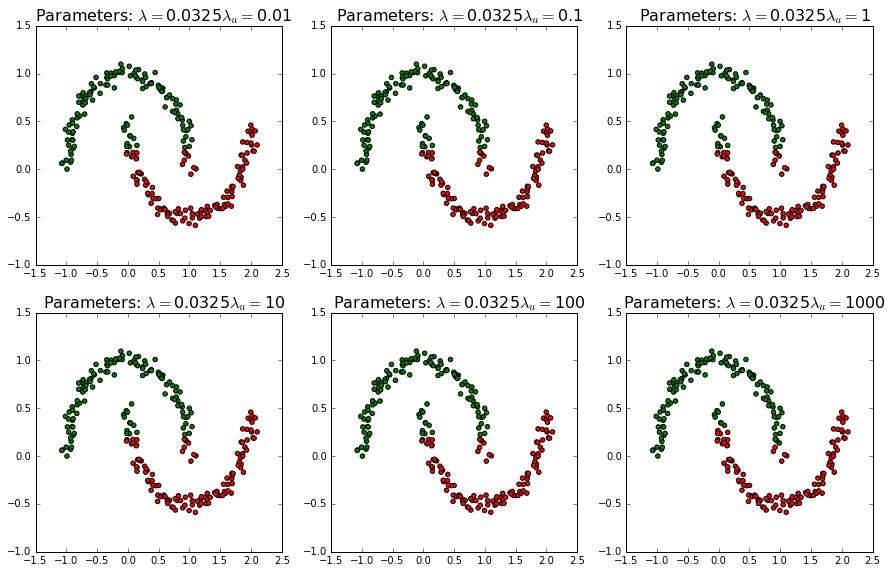

In [21]:
gamma_list = [0.01,0.1,1,10,100,1000]
lapRLS_analytics_prediction = compute_lapRLS_prediction_list_analytics(X_lab,X_unlab,Y_lab,Y_unlab,W_adj,gamma_list)[3]
#compute_lapRLS_prediction_list_analytics
gamma_A = 0.0325
titles = [" Parameters: "+r'$\lambda = $'+str(0.0325)+ r'$\lambda_u = $' +str(gl) for gl in gamma_list]
plot_binary_classification_list(ls_moons2[0][0],lapRLS_analytics_prediction,gamma_list,gamma_A,add_title_list=titles)


In [22]:
alphas_moons = compute_lapRLS_prediction_list_analytics(X_lab,X_unlab,Y_lab,Y_unlab,W_adj,gamma_list,gamma_A=gamma_A)[2]
predictions = compute_lapRLS_prediction_list_analytics(X_lab,X_unlab,Y_lab,Y_unlab,W_adj,gamma_list,gamma_A=gamma_A)[3]



## We apply our algorithm to the Cancer binary classification problem

In [23]:
cancer_X_tot = np.concatenate((Cancer.X_lab,Cancer.X_unlab),axis=0)
Cancer.y_lab = [x if x==1 else -1 for x in Cancer.y_lab]
cancer_y_unlab = np.zeros(Cancer.y_unlab.shape[0])
cancer_y_tot = np.concatenate((Cancer.y_lab,Cancer.y_unlab),axis=0)

W_adj_cancer = kneighbors_graph(cancer_X_tot,10,mode='connectivity',include_self=True).todense()

In [24]:
from sklearn.decomposition import PCA
gamma_list = [0.01,0.1,1,10,100,1000]
#lapRLS_analytics_prediction_Cancer_ = compute_lapRLS_prediction_list_analytics(Cancer.X_lab,Cancer.X_unlab,Cancer.y_lab,cancer_y_unlab,W_adj_cancer,gamma_list)[0]
lapRLS_analytics_prediction_Cancer_dic = compute_lapRLS_prediction_list_analytics(Cancer.X_lab,Cancer.X_unlab,Cancer.y_lab,cancer_y_unlab,W_adj_cancer,gamma_list)[3]

PCA = PCA(n_components=2)
PCA.fit(cancer_X_tot)
X_projected = PCA.transform(cancer_X_tot)

In [25]:
print_errors(lapRLS_analytics_prediction_Cancer_dic,cancer_y_tot)

('parameters : ', (0.03125, 1), ' misclassification rate :', 0.335676625659051)
('parameters : ', (0.03125, 0.1), ' misclassification rate :', 0.3374340949033392)
('parameters : ', (0.03125, 10), ' misclassification rate :', 0.335676625659051)
('parameters : ', (0.03125, 100), ' misclassification rate :', 0.335676625659051)
('parameters : ', (0.03125, 0.01), ' misclassification rate :', 0.3374340949033392)
('parameters : ', (0.03125, 1000), ' misclassification rate :', 0.335676625659051)


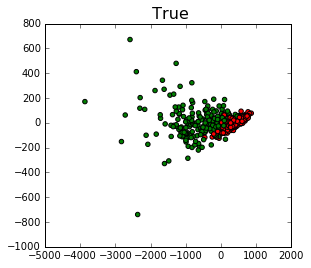

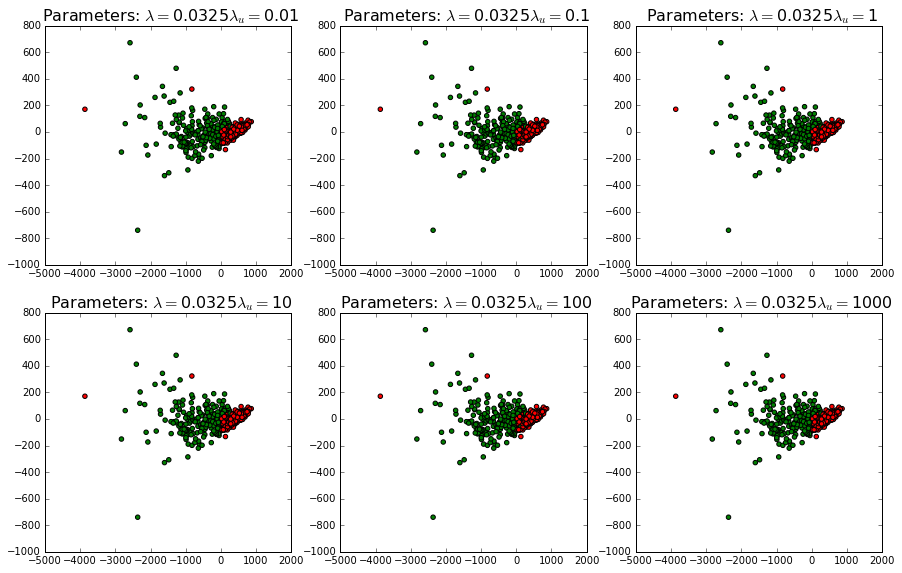

In [26]:
#plot true prediction
plot_binary_classification(X_projected[:,0],X_projected[:,1],cancer_y_tot,add_title="True")
titles = ["Parameters: "+r'$\lambda = $'+str(0.0325)+ r'$\lambda_u = $' +str(gl) for gl in gamma_list]
plot_binary_classification_list(X_projected,lapRLS_analytics_prediction_Cancer_dic
                                ,gamma_list,gamma_A,add_title_list=titles)

### Question 12 : Add your answer here

- The main issue of the closed analytical formula is as always its computational cost. Indeed, it requires to inverse a matrix. The matrix has a shape of ,  ,($n_{observation}$, $n_{observation}$). Therefore, the closed formula is in O($n_{observation}^3$) which becomes quickly untractable. 


- We tried to apply the closed formula with 10000 observation with the moons data and we didn't get the results in 2hours of running the algorithm. 


### Question 13 : Complete the code in the box below

In [27]:

#made as before for binary classification with label in {-1,1}
n_iter = 200
iis = np.random.randint(0, len(Cancer.y_lab), len(Cancer.y_lab)*n_iter)  
def grad_i(i,J,K,L,alpha,gamma_A,gamma_l,unlabeled,labeled,Y):
#    return (2/l)*(np.dot(np.dot(J,K)[i,:],np.dot(J,K)[i,:]).dot(alpha)-Y_labeled[i])+2*gamma_A*K.dot(alpha)+2*gamma_l*(u+l)**(-1)*np.dot(K,L).dot(K).dot(alpha)
    #return (2/labeled)*np.dot(J,K)[:,i].dot((np.dot(J,K)[:,i]).dot(alpha)-Y[i])+2*gamma_A*K.dot(alpha)+2*gamma_l*(unlabeled+labeled)**(-1)*np.dot(K,L).dot(K).dot(alpha)
    return (2./labeled)*np.dot(J,K)[:,i].dot(np.transpose(alpha).dot(np.dot(J,K)[:,i])-Y[i])+2.*gamma_A*K.dot(alpha)+2.*gamma_l*(unlabeled+labeled)**(-2)*np.dot(K,L).dot(K).dot(alpha)


def grad_i_(i,J,K,L,alpha,gamma_A,gamma_l,unlabeled,labeled,Y):
    n=unlabeled+labeled
    A_1 = 2. * gamma_A * np.dot(K,alpha)
    K_L_K = np.dot(K, np.dot(L, K))
    A_2 = np.array(2. * gamma_l / n**2 * np.dot(K_L_K, alpha)).flatten()
    K_J = np.dot(K, J)
    A_3 = 2./l * np.dot(K_J[:, i], alpha) * K_J[:, i]
    A_4 = -2. / l * Y[i] * K_J[:, i]
    return(A_1 + A_2 + A_3 + A_4)
    

def lapRLS_sgd(alpha_true,adjancy_matrix, grad_i, gamma_A, gamma_l#, unlabeled, labeled
        , X_lab, X_unlab, Y_labeled, Y_unlab, n_iter=n_iter, callback=None, iis=iis, step=1.):
    """Stochastic gradient descent algorithm."""
    err = []
    unlabeled = X_unlab.shape[0]
    labeled = X_lab.shape[0]
    alpha_sgd = np.zeros(unlabeled+labeled)+np.random.randn(unlabeled+labeled)*0.2    
    X_tot =  np.concatenate((X_lab,X_unlab),axis=0)
    J = block_diag(np.identity(labeled),np.zeros(shape=(unlabeled,unlabeled)))
    L = csgraph.laplacian(adjancy_matrix)
    L = (0.5*L+0.5*np.transpose(L)).astype(int)
    K = rbf_kernel(X_tot,gamma=None)
    Y = np.concatenate((Y_labeled,Y_unlab),axis=0)
    for idx in range(n_iter):
        i = iis[idx]
        ### TODO
        grad_i_value = grad_i_(i,J,K,L,alpha_sgd,gamma_A,gamma_l,unlabeled,labeled,Y)
        #print grad_i_value.shape
        alpha_sgd-=step*grad_i_value/np.sqrt(idx+1)
        ### END TODO
        err.append(np.linalg.norm(alpha_sgd-alpha_true))
        # Update metrics after each iteration.
        if callback and idx % n == 0:
            callback(alpha_sgd)
            
    f_alpha_sgd = f_alpha(alpha=alpha_sgd,K=K)
    prediction = [1 if x>=0 else -1 for x in f_alpha_sgd]
  
    return alpha_sgd, f_alpha_sgd, prediction, err


In [28]:
#run the SGD optimisation for a given list of gamma_l and a single value of gamma_A
#measures the error by using a dictionnary of alpha_true
def compute_lapRLS_prediction_list_SGD(X_lab,X_unlab,Y_lab,Y_unlab,W_adj,grad_i,gamma_l_list,alpha_true_dic,iis=iis,gamma_A=0.03125,step=0.01,n_iter=200):#, unlabeled, labeled):
    lapRLS_prediction_list = []
    alphas = {}
    predictions = {}
    errors ={}
    f_dic ={}

    for gamma_l_tested in gamma_l_list :
        lapRS_SGD = lapRLS_sgd(alpha_true_dic[(gamma_A,gamma_l_tested)],W_adj, grad_i, gamma_A, gamma_l_tested#, unlabeled, labeled
                                , X_lab, X_unlab, Y_lab, Y_unlab, n_iter=n_iter, iis=iis, step=step)
        
        predictions[(gamma_A,gamma_l_tested)] = lapRS_SGD[2]
        alphas[(gamma_A,gamma_l_tested)] = lapRS_SGD[0]
        errors[(gamma_A,gamma_l_tested)] =  lapRS_SGD[3]
        f_dic[(gamma_A,gamma_l_tested)] =  lapRS_SGD[1]

    return  gamma_l_list, alphas, predictions, errors, f_dic


In [29]:
#initialize data for moons
W_adj = kneighbors_graph(ls_moons2[0][0],2,mode='connectivity',include_self=True).todense()
u = 100
l = 150
X_lab = ls_moons2[0][0][0:l,:]
X_unlab = ls_moons2[0][0][l:l+u,:]
Y_lab = [x if x==1 else -1 for x in ls_moons2[0][1][0:l]]
Y_unlab = np.zeros(u)
#alpha_true = alphas[(gamma_A,1.)]
n_iter = 200
iis = np.random.randint(0, l, l * n_iter)  


In [30]:
n_iter = 1000
iis = np.random.randint(0, l, l * n_iter)  

In [31]:
gamma_A_tested = 0.1
gamma_list = [0.001,0.01,0.1,1,10,100,1000]

alphas_moons_true = compute_lapRLS_prediction_list_analytics(X_lab,X_unlab,Y_lab,Y_unlab,W_adj,gamma_list,gamma_A=gamma_A_tested)[2]
gamma_l_list_ , alphas_, predictions_, errors_, f_dic = compute_lapRLS_prediction_list_SGD( X_lab=X_lab, X_unlab=X_unlab
                                                                                  , Y_lab=Y_lab, Y_unlab=Y_unlab
                                                                                   , n_iter=n_iter, iis=iis,step=0.01
                                                                                   ,grad_i=grad_i
                                                                                   ,gamma_l_list=gamma_list
                                                                                   ,gamma_A=gamma_A_tested
                                                                                   ,W_adj=W_adj
                                                                                   ,alpha_true_dic=alphas_moons_true)


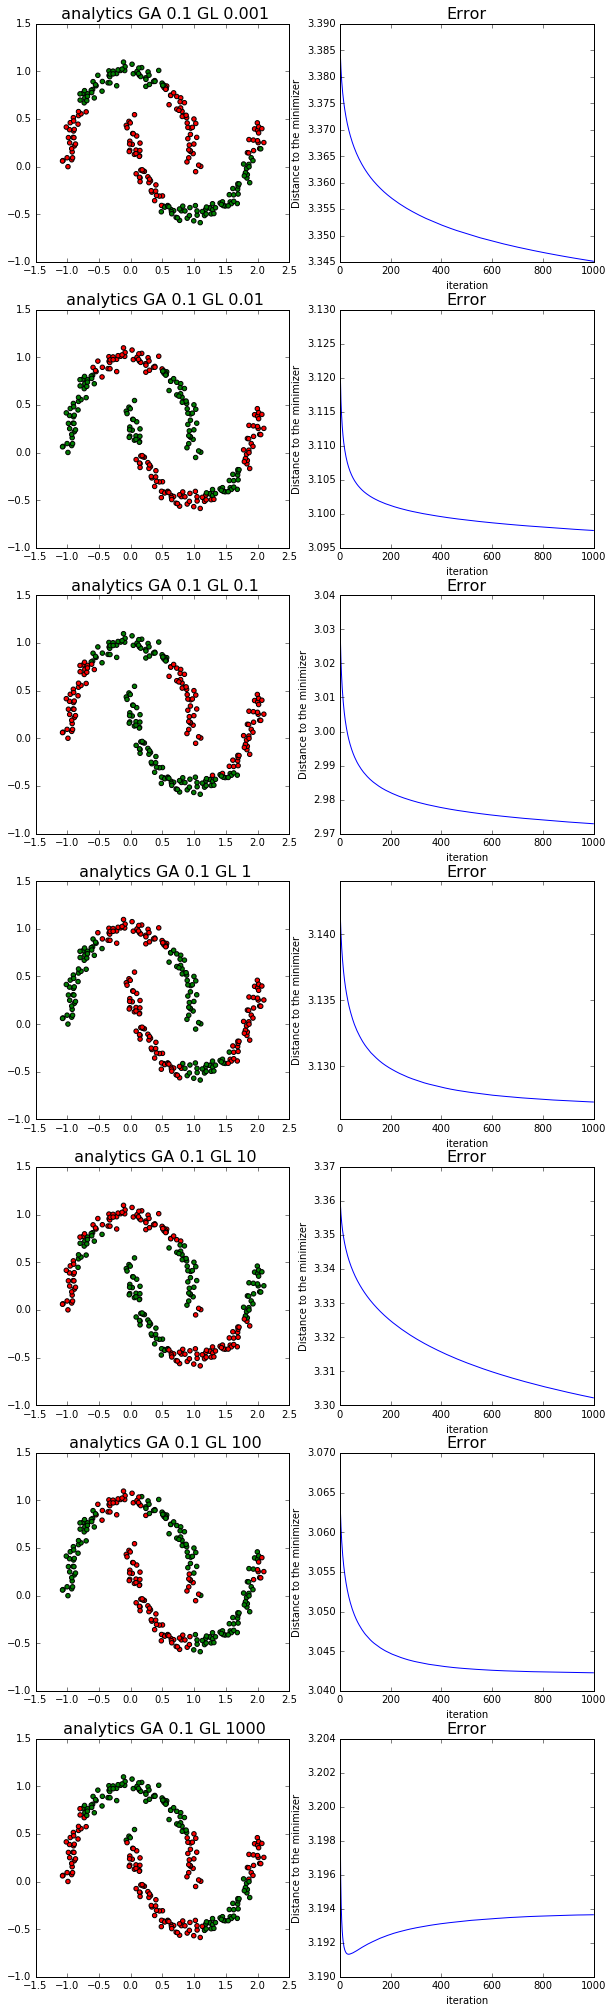

In [32]:
titles = [" analytics GA "+str(gamma_A_tested)+" GL "+str(gl) for gl in gamma_l_list_]
#plot_binary_classification_and_error(X_tot,predictions_,errors_,gamma_l_list=gamma_list,gamma_A=gamma_A_tested,add_title_list=titles, f_plot=True,f_plot_dic=f_dic)
plot_binary_classification_and_error(X_tot,predictions_,errors_,gamma_l_list=gamma_list,gamma_A=gamma_A_tested,add_title_list=titles,err=True)

In [47]:
#same with cancer
gamma_A_tested = 0.0325
gamma_list = [0.1,0.5,0.8,1]
n_iter =200
iis = np.random.randint(0, l, l * n_iter)  

alphas_cancer_true = compute_lapRLS_prediction_list_analytics(Cancer.X_lab,Cancer.X_unlab,Cancer.y_lab,Cancer.y_unlab,W_adj_cancer,gamma_list,gamma_A=gamma_A)[2]
gamma_l_list_ , alphas_, predictions_, errors_,f_dic_cancer = compute_lapRLS_prediction_list_SGD( X_lab=Cancer.X_lab, X_unlab=Cancer.X_unlab
                                                                                  , Y_lab=Cancer.y_lab, Y_unlab=Cancer.y_unlab
                                                                                   , n_iter=n_iter, iis=iis,step=0.01
                                                                                   ,grad_i=grad_i
                                                                                   ,gamma_l_list=gamma_list
                                                                                   ,gamma_A=gamma_A_tested
                                                                                   ,W_adj=W_adj_cancer
                                                                                   ,alpha_true_dic=alphas_cancer_true)


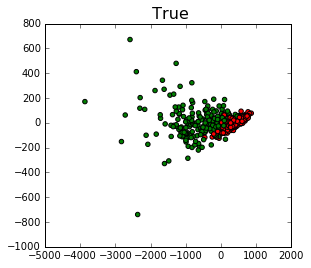

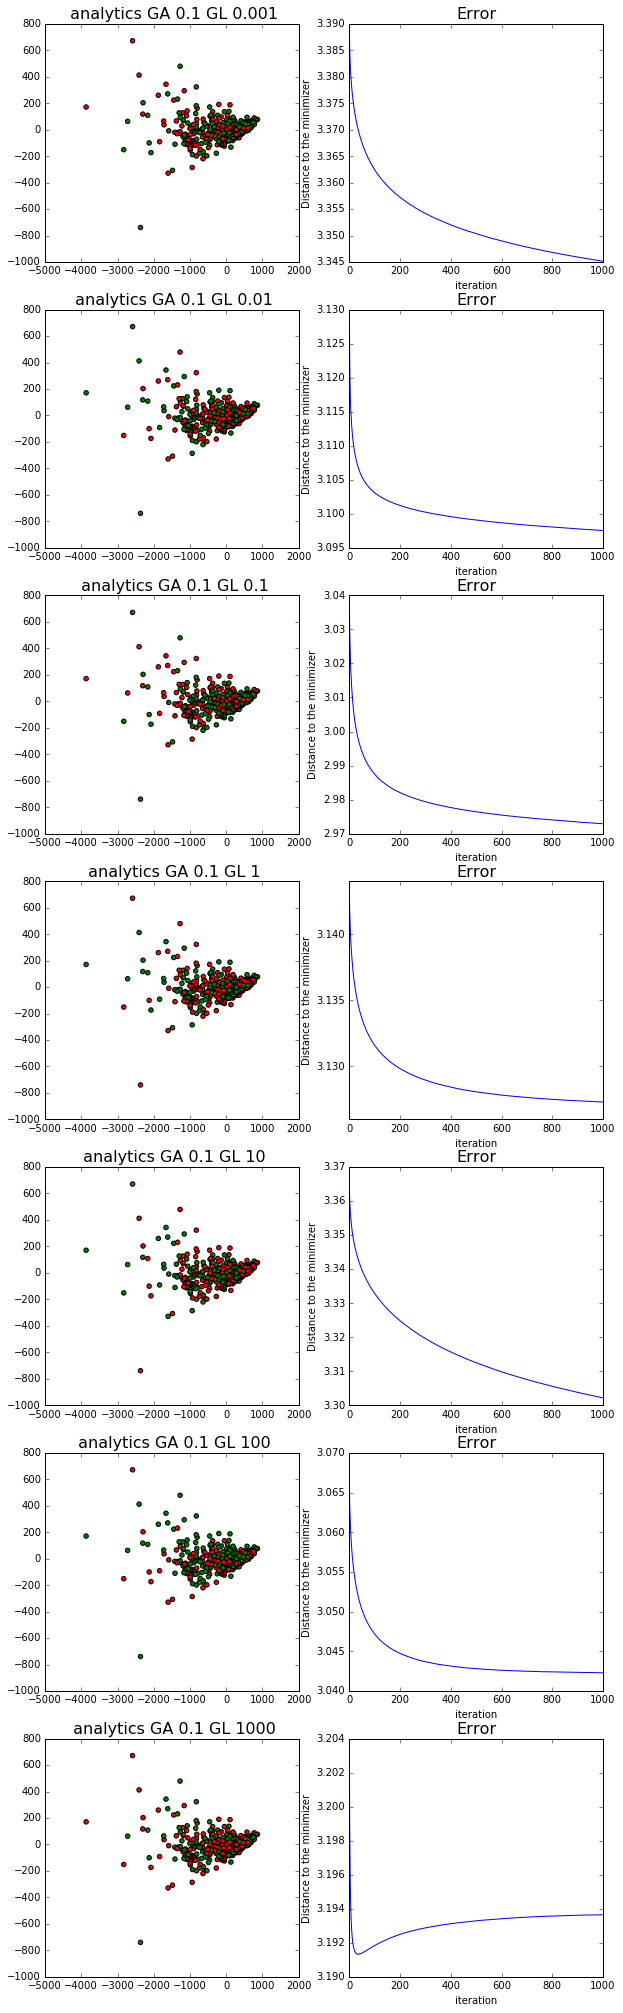

In [33]:
plot_binary_classification(X_projected[:,0],X_projected[:,1],cancer_y_tot,add_title="True")
titles = [" analytics GA "+str(gamma_A_tested)+" GL "+str(gl) for gl in gamma_l_list_]
plot_binary_classification_and_error(X_projected,predictions_,errors_,gamma_l_list=gamma_list,gamma_A=gamma_A_tested,add_title_list=titles,err=True)#, f_plot=True,f_plot_dic=f_dic_cancer)

### Question 14 : Complete the code in the box below

##### Add your answer to the question here :
With the hinge loss function and a bias term $b$ the problem becomes:
$$\min_{f \in \mathcal{H}_K} \frac{1}{l} \sum_{i=1}^l [1- y_i (f(x_i)+b)]_+ + \lambda \| f \|_K^2 + \frac{\lambda_u}{(u+l)^2} \mathbf{f}^\top L \mathbf{f}$$
In the primal, the problem is expressed as follows:
$$\min_{\alpha \in \mathbb{R}^{l+u}, \xi \in \mathbb{R}^l} \frac{1}{l} \sum_{i=1}^l \xi_i + \lambda \alpha^\top K \alpha + \frac{\lambda_u}{(u+l)^2} \alpha^\top KLK \alpha$$
with constraints:
$$y_i \left( \sum_{j=1}^{l+u} \alpha_j K(x_i,x_j) + b \right) \geq 1 - \xi_i$$
$$\xi_i \geq 0$$
for $i=1,...,l$.

Which can be solved in the dual as: 
$$\boxed{\min_{\beta \in \mathbb{R}^l}  \frac{1}{2} \beta^\top Q \beta - \sum_{i=1}^l \beta_i}$$
with constraints: 
$$\sum_{i=1}^l \beta_i y_i = 0$$
$$0 \leq \beta_i \leq \frac{1}{l}, i =1,...,l$$
where:

$$Q = YJK \left(2 \lambda \cdot Id_n + 2 \frac{\lambda_u}{(u+l)^2} LK \right)^{-1} J^\top Y$$

$$Y = \mathrm{diag}(y_1,...,y_l)$$

$$J = [Id_l, 0_{l \times u}]$$
The solution can be written as:
$$\alpha^* = (2 \lambda Id_n + 2 \frac{\lambda_u}{(u+l)^2} LK)^{-1} J^\top Y \beta^*$$


In [69]:
import cvxopt

def laplacian(A,k):
    Ad = kneighbors_graph(A, mode='connectivity', n_neighbors=k, include_self=False)
    Ad_dense =Ad.todense()
    n = Ad_dense.shape[0]
    d = np.sum(Ad_dense,axis=0)
    D = np.zeros((n,n))
    D[np.diag_indices_from(D)] = d
    L = D - Ad_dense
    return L

def alpha_lapsvm(S, X_unlab, y_lab, kernel, lbda, lbda_u):
    #Parameters and reshaping
    y_lab[y_lab == 0] = -1
    l = len(y_lab)
    u = X_unlab.shape[0]
    Y = np.diag(y_lab)
    X_tot = np.concatenate((S, X_unlab), axis=0)
    #L = laplacian(X_tot,10)
    Ad = kneighbors_graph(X_tot, mode='connectivity', n_neighbors=15, include_self=False)
    Ad_dense =Ad.todense()
    L = csgraph.laplacian(Ad_dense)
    L = (0.5*L+0.5*np.transpose(L)).astype(int)
    
    
    n = X_tot.shape[0]
    K = kernel(X_tot)
    
    J = np.zeros((l,n))
    J[:,:l] = np.eye(l)
    
    #compute Q
    temp_inv = np.linalg.inv(2*lbda*l*np.eye(n) + 2*lbda_u*l / (u + l)**2 * np.dot(L,K))
    Q=np.dot(Y,np.dot(J,np.dot(K,np.dot(temp_inv,np.dot(np.transpose(J),Y)))))
    
    q =-np.ones(l)
    G = np.zeros((2*l,l))
    G[:l,:] = -np.eye(l)
    G[l:,:] = np.eye(l)
    h = np.zeros(2*l)
    h[l:] = np.ones(l)*1/l
     
    #Parameters to use cvxopt and compute Beta
    P = cvxopt.matrix(Q)
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    q = cvxopt.matrix(q)
    A = np.zeros((1,l))
    A[0] = y_lab
    A = cvxopt.matrix(A)
    B = np.zeros((1,1))
    B = cvxopt.matrix(B)
    Beta = cvxopt.solvers.qp(P,q,G,h,A,B)['x']
    
    #Compute alpha
    alpha = np.dot(np.dot(temp_inv,np.dot(np.transpose(J),Y)),Beta)
    return alpha
                                         

In [70]:
def f_alpha_(X_lab,X_unlab,y_lab,kernel,lbda,lbda_u):
    alpha=alpha_lapsvm(X_lab,X_unlab,y_lab, kernel,lbda, lbda_u)
    X_tot = np.concatenate((X_lab, X_unlab), axis=0)
    f=np.dot(rbf_kernel(X_tot,gamma=None),alpha)
    f=np.sign(f)
    return f

#Test on non-noisy moon dataset
X_lab_moon,X_unlab_moon ,y_moon_lab,y_moon_unlab = train_test_split(ls_moons[0][0],
                                                                    ls_moons[0][1], 
                                                    train_size=0.8, random_state=32)
lbda =0.1

prediction = f_alpha(X_lab_moon,X_unlab_moon ,y_moon_lab,kernel=rbf_kernel,lbda=0.1,lbda_u=0.001)

     pcost       dcost       gap    pres   dres
 0: -5.9729e+01 -7.3298e+00  8e+02  3e+01  3e-16
 1: -5.1926e+00 -2.2272e+00  2e+01  9e-01  5e-16
 2: -8.5896e-01 -2.0142e+00  1e+00  2e-16  1e-15
 3: -9.4857e-01 -1.0692e+00  1e-01  2e-17  6e-16
 4: -9.9750e-01 -9.9908e-01  2e-03  2e-17  5e-16
 5: -9.9820e-01 -9.9822e-01  2e-05  2e-17  4e-16
 6: -9.9821e-01 -9.9821e-01  2e-07  2e-17  4e-16
Optimal solution found.


In [71]:
lbda_list = [0.001,0.1,1,10,100]
lbda_u_list = [0.001,0.1,1,10,100]
prediction_dic = {}
for lbda in lbda_list :
    for lbda_u in lbda_u_list:
        prediction_dic[(lbda,lbda_u)] = f_alpha(X_lab_moon,X_unlab_moon ,y_moon_lab,kernel=rbf_kernel,lbda=lbda,lbda_u=lbda_u)

     pcost       dcost       gap    pres   dres
 0: -9.5285e+00 -4.9115e+00  7e+02  3e+01  1e-15
 1: -3.8873e+00 -3.0855e+00  4e+01  2e+00  1e-15
 2: -9.7033e-01 -2.0376e+00  3e+00  7e-02  1e-15
 3: -7.5234e-01 -1.1630e+00  4e-01  4e-17  9e-16
 4: -8.0696e-01 -8.3255e-01  3e-02  1e-17  4e-16
 5: -8.2106e-01 -8.2146e-01  4e-04  2e-17  3e-16
 6: -8.2133e-01 -8.2133e-01  4e-06  3e-17  4e-16
 7: -8.2133e-01 -8.2133e-01  4e-08  3e-17  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.6328e+00 -4.9805e+00  7e+02  3e+01  1e-15
 1: -3.9637e+00 -3.1255e+00  4e+01  2e+00  8e-16
 2: -1.0125e+00 -2.0508e+00  3e+00  7e-02  9e-16
 3: -7.7400e-01 -1.1849e+00  4e-01  2e-17  8e-16
 4: -8.2865e-01 -8.5049e-01  2e-02  1e-17  4e-16
 5: -8.4071e-01 -8.4097e-01  3e-04  2e-17  4e-16
 6: -8.4087e-01 -8.4087e-01  3e-06  1e-17  3e-16
 7: -8.4087e-01 -8.4087e-01  3e-08  2e-17  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.5274e+00 -4.9108e

In [ ]:
def plot_binary_classification_svm(data_x_y,binary_prediction_dic,add_title_list=[]):
    i=0
    if add_title_list==[]:
        #add_title_list=["" for i in range(len(binary_prediction_list))]
        add_title_list=["" for e in range(len(binary_prediction_dic))]
    getColors = lambda y : ['red' if yy==1 else 'green' for yy in y]
    gs = gridspec.GridSpec(len(binary_prediction_dic), 3)
    plt.figure(figsize=(15, 5*len(binary_prediction_dic)))
    #for i in range(len(binary_prediction_list)):
    for e in binary_prediction_dic:
        plt.subplot(gs[int(i/3), i%3])
        plt.title(" "+add_title_list[i], fontsize=16)
        #plt.scatter(x=data_x_y[:,0],y=data_x_y[:,1],c=getColors(binary_prediction_list[i]))
        plt.scatter(x=data_x_y[:,0],y=data_x_y[:,1],c=getColors(binary_prediction_dic[e]))
        i=i+1

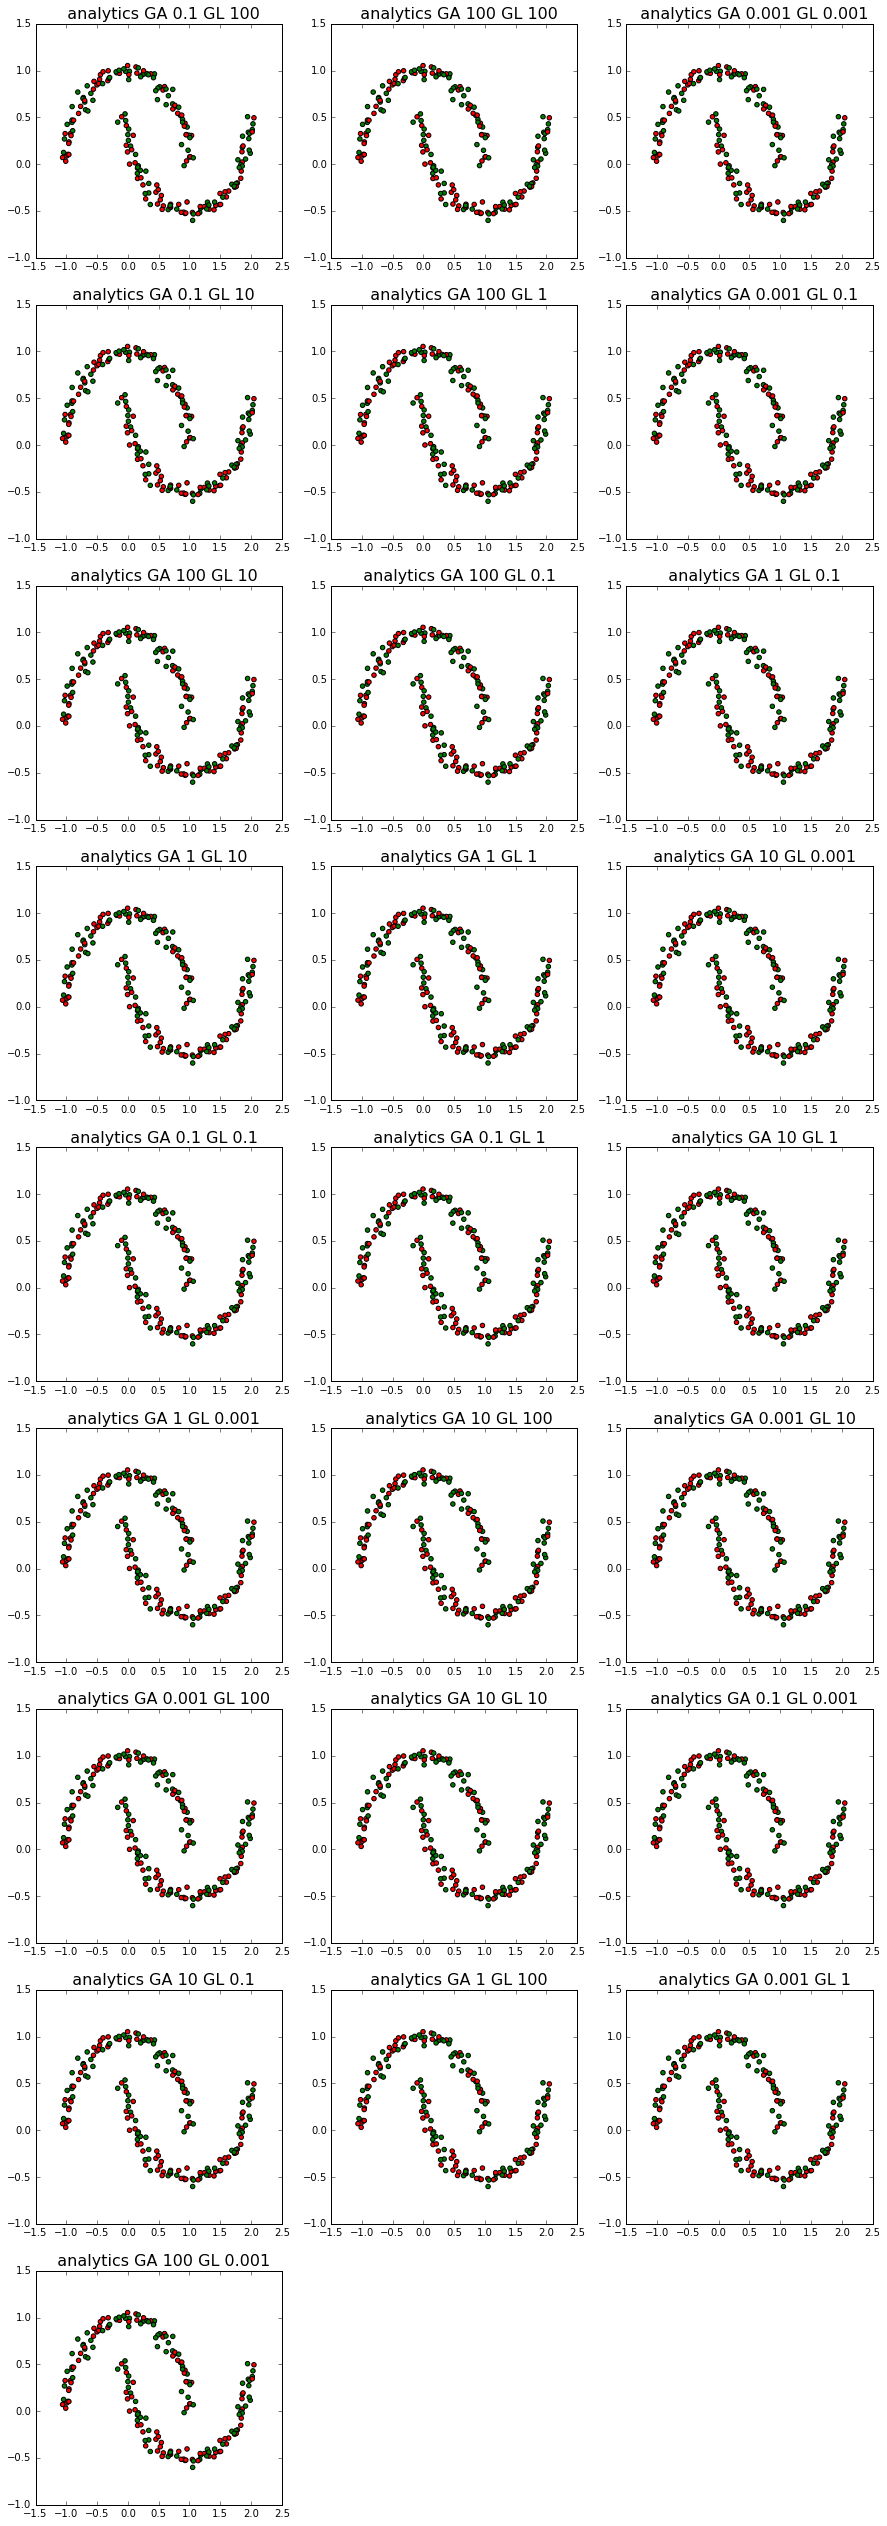

In [65]:
X_tot =ls_moons[0][0]
#print X_tot
titles = [" analytics GA "+str(e[0])+" GL "+str(e[1]) for e in prediction_dic]
plot_binary_classification_svm(data_x_y=X_tot,binary_prediction_dic=prediction_dic,add_title_list=titles)


Le résultat ici n'est pas convaincant. Après de multitude vérification de nos calculs nous n'avons malheureusement pas trouvé l'erreur

### Question 15 : Complete the code in the box below

### Question 16 : Complete the code in the box below

###### Describe your protocol here : 

In the same way that we did earlier : 
- First, we can use a sampling algorithm like stratified sampling in order to reduce the dimensionality of our problem
- We train each model on a SubSample of the data set. If some hyperparameters have to be choosen we do a grid search. regularization hyperparameters, and we measure the error on the complementary sample.
- We pick the model with the best prediction error (by using the true error). If the prediction is very close we can add a stability measure by applying the algorithm we define at the begining on our training data set.
- Finnaly, we can retrain our model on using the entire data set (now that we only have one model to train)
